In [ ]:
# --- Install required libraries ---
!pip install torch torchvision matplotlib medmnist pytorch-fid --quiet

In [1]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from torch.utils.data import ConcatDataset

import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import torchvision.transforms.functional as F

import torch.nn.functional as fun

import medmnist
from medmnist import INFO, Evaluator

from VAE import VAE

import os
from torchvision.utils import save_image
from PIL import Image
import torchvision.transforms as transforms

In [2]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.2 @ https://github.com/MedMNIST/MedMNIST/


# We first work on a 2D dataset with size 28x28

In [3]:
data_flag = 'bloodmnist'
download = True
BATCH_SIZE = 128

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

## First, we read the MedMNIST data, preprocess them, concatenate them and encapsulate them into dataloader form.

In [4]:

# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load all splits
train = DataClass(split='train', transform=data_transform, download=True)
val = DataClass(split='val', transform=data_transform, download=True)
test = DataClass(split='test', transform=data_transform, download=True)

# Combine them into a single dataset
full_dataset = ConcatDataset([train, val, test])
dataloader = DataLoader(full_dataset, batch_size=128, shuffle=True)

train_dataloader = DataLoader(train, batch_size=128, shuffle=True)
val_dataloader = DataLoader(val, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test, batch_size=128, shuffle=True)

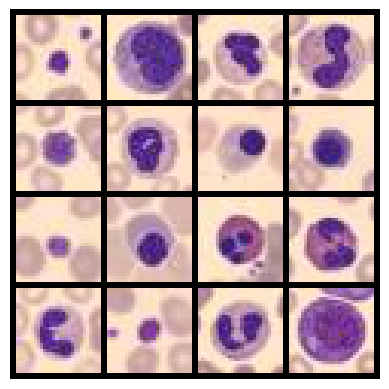

In [12]:
# visualization
# Get a few samples
samples = [full_dataset[i][0] for i in range(16)]  # assuming (image, label) tuples

# Make a grid
grid = make_grid(samples, nrow=4)

# Display
plt.imshow(F.to_pil_image(grid))
plt.axis('off')
plt.show()

In [34]:
stuff = [int(full_dataset[i][1][0]) for i in range(100)]

print(stuff)

[7, 3, 6, 6, 7, 6, 2, 2, 7, 2, 1, 1, 6, 7, 6, 3, 7, 2, 6, 1, 6, 1, 5, 5, 7, 7, 0, 6, 4, 5, 3, 2, 1, 1, 6, 6, 1, 4, 0, 4, 6, 3, 0, 1, 1, 5, 3, 0, 3, 5, 1, 7, 4, 4, 1, 7, 6, 6, 2, 1, 6, 4, 4, 3, 5, 1, 3, 1, 1, 7, 1, 7, 3, 3, 1, 1, 5, 3, 6, 0, 6, 0, 3, 7, 3, 3, 0, 1, 3, 4, 7, 1, 0, 6, 6, 7, 2, 6, 3, 5]


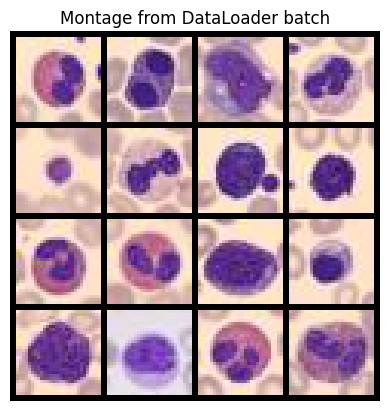

In [6]:
#Another option to visualize the dataset
data_iter = iter(dataloader)
images, labels = next(data_iter)  # get one batch

# Make grid
grid = make_grid(images[:16], nrow=4)  # you can adjust how many to show

# Display
plt.imshow(F.to_pil_image(grid))
plt.axis('off')
plt.title("Montage from DataLoader batch")
plt.show()

In [7]:
#assess image size
print(f"Image size: {images[0].shape}")

#assess label size
print(f"Label size: {labels[0].shape}")

#assess label values
s = set()
for i in range(len(labels)):
    s.add(labels[i].item())
print(f"Label values: {s}")

Image size: torch.Size([3, 28, 28])
Label size: torch.Size([1])
Label values: {0, 1, 2, 3, 4, 5, 6, 7}


In [8]:
def loss_function(recon_x, x, mu, logvar):
    recon_loss = fun.mse_loss(recon_x, x, reduction='sum')
    # KL divergence
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VAE(train_dataloader, val_dataloader, test_dataloader, latent_dim=128)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

dummy_data = torch.randn(8, 3, 28, 28)  # Batch of 8 RGB images

train_loss, val_loss = model.train(num_epochs=100, loss_function=loss_function, optimizer=optimizer)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (128x1152 and 576x128)

In [11]:
def show_images(images, nrow=4):
    """Display a batch of images (Tensor: N x 3 x 28 x 28)"""
    images = images.detach().cpu().numpy()
    images = np.transpose(images, (0, 2, 3, 1))  # N x H x W x C
    fig, axs = plt.subplots(nrow, nrow, figsize=(nrow * 2, nrow * 2))
    for i in range(nrow * nrow):
        ax = axs[i // nrow, i % nrow]
        ax.imshow(images[i])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def generate_images(model, latent_dim=64, n_samples=16):
    #model.eval()
    with torch.no_grad():
        z = torch.randn(n_samples, latent_dim)  # Sample from standard normal
        generated = model.decode(z)
        show_images(generated, nrow=int(n_samples ** 0.5))

def generate_and_save_images(model, latent_dim=64, n_samples=16, output_dir="generated_images"):
    os.makedirs(output_dir, exist_ok=True)

    with torch.no_grad():
        z = torch.randn(n_samples, latent_dim).to(device)
        generated = model.decode(z).cpu()  # Shape: (n_samples, 3, 28, 28)

    for i in range(n_samples):
        img_tensor = generated[i]
        img_pil = transforms.ToPILImage()(img_tensor)  # Convert to PIL format
        img_pil.save(os.path.join(output_dir, f"sample_{i+1:03d}.png"))
        # Or use save_image(generated[i], path) if you prefer torchvision

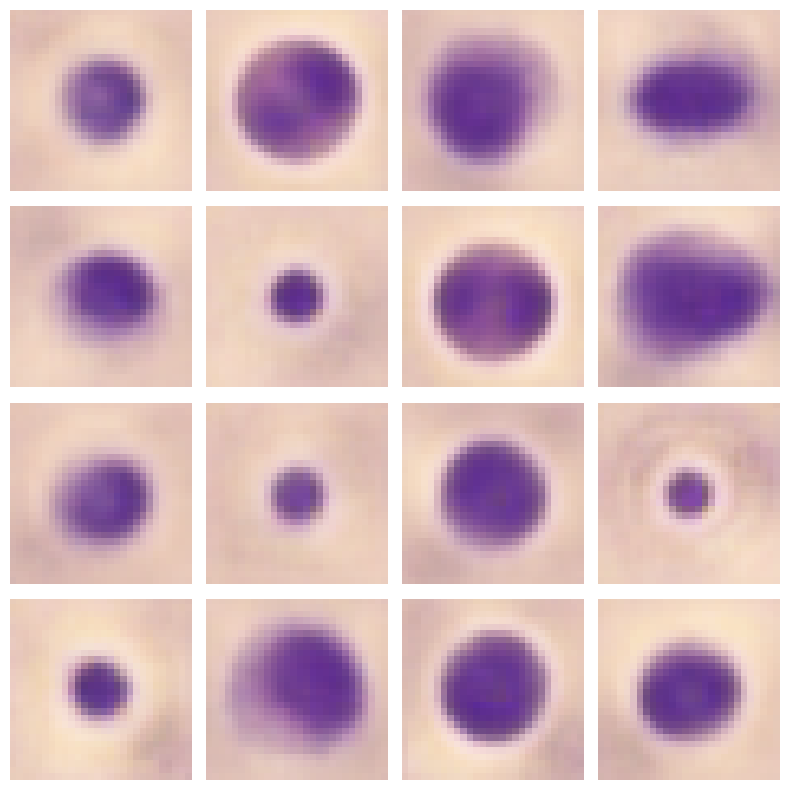

In [22]:
generate_images(model, latent_dim=64, n_samples=16)

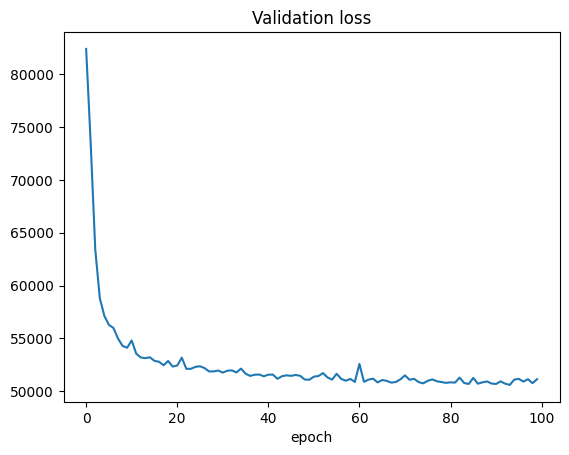

In [21]:
plt.plot(val_loss);
plt.title('Validation loss');
plt.xlabel('epoch');

## Testing VAE

### Escolher 10 mil amostras aleatórias do dataset original

In [13]:
# Generate a random permutation of indices
perm = torch.randperm(len(full_dataset))[:10000]

# Convert to list if needed
subset = Subset(full_dataset, perm.tolist())

# Create a DataLoader for the subset
new_dataloader = DataLoader(subset, batch_size=128, shuffle=True)

In [14]:
# Folder to save images
save_dir = "real_images"
os.makedirs(save_dir, exist_ok=True)

# Optional: transform tensor to PIL image
to_pil = transforms.ToPILImage()

# Loop through the dataloader and save images
image_counter = 0
for batch in tqdm(new_dataloader):
    images, _ = batch  # assuming dataset returns (image, label)
    for img in images:
        pil_img = to_pil(img)  # convert tensor to PIL image
        pil_img.save(os.path.join(save_dir, f"img_{image_counter:05d}.png"))
        image_counter += 1

100%|██████████| 79/79 [00:08<00:00,  9.60it/s]


### Gerar 10 mil imagens a partir do dataset treinado

In [15]:
generate_and_save_images(model, latent_dim=64, n_samples=10000, output_dir='fake_images')

### Calcular o 'FID score'

In [16]:
from pytorch_fid import fid_score

fid_value = fid_score.calculate_fid_given_paths(
    ['real_images', 'fake_images'],
    batch_size=32,
    device='cuda',
    dims=64
)
print('FID:', fid_value)

100%|██████████| 313/313 [01:38<00:00,  3.17it/s]

FID: 0.3366372769694792
